# **Predicting Customer Recommendations**
### Abigail McDonald

##Objective

A dataset from an e-commerce retailer selling women’s apparel contains the following elements: item id, text reviews, rating, recommended(yes/no), positive feedback on review, age of customer, division/department/class of product.  Moving forward, can we predict customer recommendation of a product based on the review given?  This will involve building and testing models to predict customer recommendation of purchased products based on review text analysis.

## Data Retrieval and Cleaning

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

df = pd.read_csv('https://github.com/dipanjanS/text-analytics-with-python/raw/master/media/Womens%20Clothing%20E-Commerce%20Reviews%20-%20NLP.csv', keep_default_na=False) 
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [2]:
# Combining Title and Review Text Columns
df["Review"] = df["Title"]+" "+ df["Review Text"]

# Dropping individual columns
df = df.drop(df.columns[[2, 3]], axis=1)

# Removing blank review records
df["Review"].replace("", np.nan, inplace=True)
df.dropna(subset = ["Review"], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23486 entries, 0 to 23485
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Clothing ID              23486 non-null  int64 
 1   Age                      23486 non-null  int64 
 2   Rating                   23486 non-null  int64 
 3   Recommended IND          23486 non-null  int64 
 4   Positive Feedback Count  23486 non-null  int64 
 5   Division Name            23486 non-null  object
 6   Department Name          23486 non-null  object
 7   Class Name               23486 non-null  object
 8   Review                   23486 non-null  object
dtypes: int64(5), object(4)
memory usage: 1.8+ MB


##Exploratory Data Analysis

###Visualization of Columns of Interest

Rating  Recommended IND
5       1                  13106
        0                     25
4       1                   4909
        0                    168
3       0                   1682
        1                   1189
2       0                   1471
        1                     94
1       0                    826
        1                     16
dtype: int64
Division Name   Department Name  Class Name    
                                                     14
General         Bottoms          Casual bottoms       2
                                 Jeans              787
                                 Pants              835
                                 Shorts             317
                                 Skirts             601
                Dresses          Dresses           3730
                Jackets          Jackets            397
                                 Outerwear          248
                Tops             Blouses           1993
                         

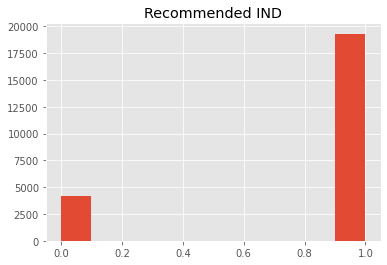

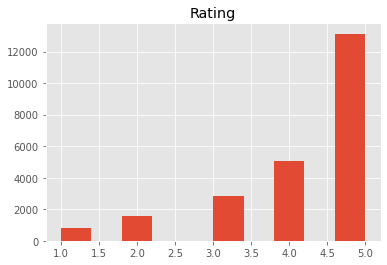

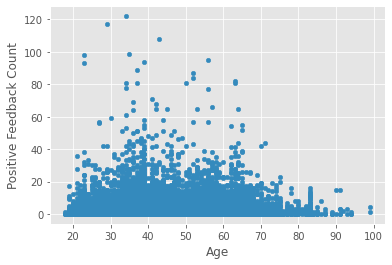

In [3]:
#Recommended Products
df.hist(column="Recommended IND")

#Ratings
df.hist(column="Rating")

#Ratings vs Recommendations
rating = df[['Rating','Recommended IND']].value_counts()[[5,4,3,2,1]]
print (rating)

#Product Class/Division/Department Name
types = df[['Division Name','Department Name','Class Name']].value_counts(sort=False)
print (types)

#Age vs Feedback on Reviews
df.plot.scatter(x = "Age", y = "Positive Feedback Count")


Top Product IDs
Product ID  count
 1078    1024
862      806
1094     756
1081     582
872      545
829      527
1110     480
868      430
895      404
Name: Clothing ID, dtype: int64
Top Recommended Products
 Clothing ID  Recommended IND
1078         1                  841
862          1                  661
1094         1                  621
1081         1                  494
872          1                  478
829          1                  436
1110         1                  403
895          1                  341
868          1                  325
dtype: int64


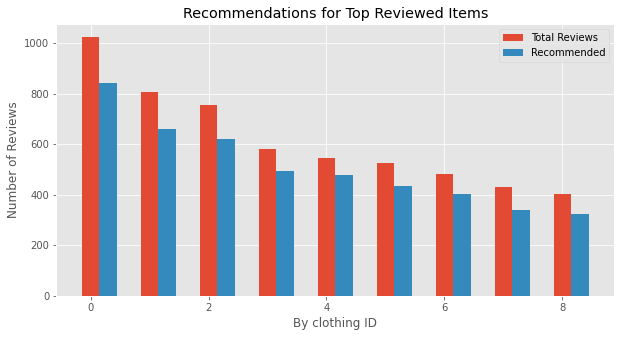

In [4]:
#Top Product IDs (list)
top = df['Clothing ID'].value_counts(ascending=False)
top_rat = top.nlargest(9)
print ("Top Product IDs\nProduct ID  count\n",top_rat)

#Customers who recommended/did not recommend top product IDs (bars)
rec = df[['Clothing ID','Recommended IND']].value_counts(ascending=False)
top_rec = rec.nlargest(9)
print ("Top Recommended Products\n",top_rec)

# Numbers of pairs of bars you want
N = 9

# Data on X-axis

# Specify the values of blue bars (height)
blue_bar = top_rat
# Specify the values of orange bars (height)
orange_bar = top_rec

# Position of bars on x-axis
ind = np.arange(N)

# Figure size
plt.figure(figsize=(10,5))

# Width of a bar 
width = 0.3       

# Plotting
plt.bar(ind, blue_bar , width, label='Total Reviews')
plt.bar(ind + width, orange_bar, width, label='Recommended')

plt.xlabel('By clothing ID')
plt.ylabel('Number of Reviews')
plt.title('Recommendations for Top Reviewed Items')

# xticks()
# First argument - A list of positions at which ticks should be placed
# Second argument -  A list of labels to place at the given locations
#plt.xticks(ind + width / 2, "")

# Finding the best position for legends and putting it
plt.legend(loc='best')
plt.show()

###Textual Data Analysis

In [5]:
# additional libraries and dependencies
!pip install contractions
!pip install textsearch
!pip install tqdm
import nltk
import contractions
from bs4 import BeautifulSoup
import re
from tqdm import tqdm
import unicodedata
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('gutenberg')
nltk.download('punkt')
from operator import itemgetter
import itertools

#preprocess text functions 

def strip_html_tags(text):
  soup = BeautifulSoup(text, "html.parser")
  [s.extract() for s in soup(['iframe', 'script'])]
  stripped_text = soup.get_text()
  stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
  return stripped_text

def remove_accented_chars(text):
  text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
  return text

def pre_process_corpus(docs):
  norm_docs = []
  for doc in tqdm(docs):
    # strip HTML tags
    doc = strip_html_tags(doc)
    # remove extra newlines and convert them to spaces
    doc = doc.translate(doc.maketrans("\n\t\r", "   "))
    # lower case
    doc = doc.lower()
    # remove accents
    doc = remove_accented_chars(doc)
    # fix contractions
    doc = contractions.fix(doc)
    # remove special characters
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, flags=re.I|re.A)
    # remove extra whitespaces
    doc = re.sub(' +', ' ', doc)
    # remove leading and training whitespaces
    doc = doc.strip()  
    norm_docs.append(doc)
  
  return norm_docs

     |████████████████████████████████| 321 kB 8.1 MB/s 
     |████████████████████████████████| 284 kB 42.7 MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85456 sha256=cea49f63f983eaa5d2013218b93d2bd6a838aa1768e305d29552e130f060c670
  Stored in directory: /root/.cache/pip/wheels/25/19/a6/8f363d9939162782bb8439d886469756271abc01f76fbd790f
Successfully built pyahocorasick
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Unzipping corpora/gutenberg.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [6]:
reviews = df['Review'].values
preprocess_review = pre_process_corpus(reviews)

100%|██████████| 23486/23486 [00:04<00:00, 5361.17it/s]


In [7]:
#lengths of reviews
print ("The total number of reviews is:", len(preprocess_review))

#words per review
avg = sum(len(word) for word in preprocess_review) / len(preprocess_review) 
print ("The average word length for each review is:", avg)

The total number of reviews is: 23486
The average word length for each review is: 305.9248488461211


In [8]:
#most common words and n-grams

stop_words = nltk.corpus.stopwords.words('english')

def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, flags=re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = nltk.word_tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

norm_data = list(filter(None, [normalize_document(line)
                                      for line in preprocess_review]))

def compute_ngrams(sequence, n):
    return list(
            zip(*(sequence[index:] 
                     for index in range(n)))
    )
def flatten_corpus(corpus):
    return ' '.join([document.strip() 
                     for document in corpus])
    
def get_top_ngrams(corpus, ngram_val=1, limit=5):

    corpus = flatten_corpus(corpus)

    # tokenize words
    tokens = nltk.word_tokenize(corpus)

    ngrams = compute_ngrams(tokens, ngram_val)
    ngrams_freq_dist = nltk.FreqDist(ngrams)
    sorted_ngrams_fd = sorted(ngrams_freq_dist.items(), 
                              key=itemgetter(1), reverse=True)
    sorted_ngrams = sorted_ngrams_fd[0:limit]

    # join all ngrams
    sorted_ngrams = [(' '.join(text), freq) 
                     for text, freq in sorted_ngrams]

    return sorted_ngrams

print ("The most common review words are:\n", get_top_ngrams(corpus=norm_data, ngram_val=1,
               limit=10))

print ("The most common bigrams are:\n", get_top_ngrams(corpus=norm_data, ngram_val=2,
               limit=10))

print ("The most common trigrams are:\n", get_top_ngrams(corpus=norm_data, ngram_val=3,
               limit=10))

The most common review words are:
 [('dress', 12104), ('love', 10775), ('size', 8894), ('top', 8493), ('great', 7864), ('fit', 7845), ('like', 7223), ('wear', 6530), ('would', 6148), ('fabric', 5034)]
The most common bigrams are:
 [('true size', 1322), ('love dress', 902), ('love love', 714), ('usually wear', 690), ('love top', 640), ('looks great', 634), ('fit perfectly', 598), ('well made', 553), ('size small', 522), ('super cute', 517)]
The most common trigrams are:
 [('fits true size', 272), ('love love love', 246), ('fit true size', 215), ('received many compliments', 166), ('runs true size', 142), ('usually wear size', 133), ('ordered usual size', 105), ('dress love dress', 104), ('really wanted love', 102), ('wanted love dress', 95)]


In [9]:
#target leakage: removing reviews with a rating of 3 as the reviews are evenly balanced between recommend (1) and do not recommend (0)
print ("The array before removal of Rating = 3:", df.shape)
df = df.loc[(df["Rating"] != 3)]
print ("The array after removal of Rating = 3:", df.shape)

The array before removal of Rating = 3: (23486, 9)
The array after removal of Rating = 3: (20615, 9)


##Feature Engineering and Modeling

###Sentiment Analysis Features

In [10]:
# train data
reviews = df['Review'].values
sentiments = df['Recommended IND'].values

# 70 percent of reviews are training data
train_reviews = reviews[:14430]
train_sentiments = sentiments[:14430]

# 30 percent of reviews are testing data
test_reviews = reviews[14430:]
test_sentiments = sentiments[14430:]

# preprocess text
norm_train_reviews = pre_process_corpus(train_reviews)
norm_test_reviews = pre_process_corpus(test_reviews)

100%|██████████| 6185/6185 [00:01<00:00, 5467.67it/s]


###Feature Engineering

BOW Based Features

In [11]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# build BOW features on train reviews
cv = CountVectorizer(binary=False, min_df=5, max_df=1.0, ngram_range=(1,3))
cv_train_features = cv.fit_transform(norm_train_reviews)

# transform test reviews into features
cv_test_features = cv.transform(norm_test_reviews)

print('BOW model:> Train features shape:', cv_train_features.shape, 
      ' Test features shape:', cv_test_features.shape)

BOW model:> Train features shape: (14430, 43094)  Test features shape: (6185, 43094)


TF-IDF Based Features

In [12]:
# build TFIDF features on train reviews
tv = TfidfVectorizer(use_idf=True, min_df=5, max_df=1.0, ngram_range=(1,2),
                     sublinear_tf=True)
tv_train_features = tv.fit_transform(norm_train_reviews)

# transform test reviews into features
tv_test_features = tv.transform(norm_test_reviews)

print('TF-IDF model:> Train features shape:', tv_train_features.shape, 
      ' Test features shape:', tv_test_features.shape)

TF-IDF model:> Train features shape: (14430, 24683)  Test features shape: (6185, 24683)


###Machine Learning Models

**Multinomial Naive Bayes Model**

In [13]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report

# instantiate model
clf = MultinomialNB(alpha=1.0, fit_prior=True)

In [14]:
# Multinomial Naive Bayes CV

# train model
clf.fit(cv_train_features, train_sentiments)

# predict on test data
mnb_bow_predictions = clf.predict(cv_test_features)

In [15]:
# evaluation
print(classification_report(test_sentiments, mnb_bow_predictions))

# confusion matrix
labels = ['negative', 'positive']
pd.DataFrame(confusion_matrix(test_sentiments, mnb_bow_predictions), 
             index=labels, columns=labels)

              precision    recall  f1-score   support

           0       0.68      0.87      0.76       781
           1       0.98      0.94      0.96      5404

    accuracy                           0.93      6185
   macro avg       0.83      0.90      0.86      6185
weighted avg       0.94      0.93      0.94      6185



,negative,positive
negative,678,103
positive,315,5089


In [16]:
# Multinomial Naive Bayes TFIDF

# train model
clf.fit(tv_train_features, train_sentiments)

# predict on test data
mnb_tfidf_predictions = clf.predict(tv_test_features)

In [17]:
# evaluation
print(classification_report(test_sentiments, mnb_tfidf_predictions))

# confusion matrix
labels = ['negative', 'positive']
pd.DataFrame(confusion_matrix(test_sentiments, mnb_tfidf_predictions), 
             index=labels, columns=labels)

              precision    recall  f1-score   support

           0       1.00      0.05      0.09       781
           1       0.88      1.00      0.94      5404

    accuracy                           0.88      6185
   macro avg       0.94      0.52      0.51      6185
weighted avg       0.89      0.88      0.83      6185



,negative,positive
negative,36,745
positive,0,5404


**Logistic Regression Model**

In [18]:
from sklearn.linear_model import LogisticRegression

# instantiate model
lr = LogisticRegression(penalty='l2', 
                        max_iter=500, 
                        C=1, 
                        solver='liblinear', 
                        random_state=42)

In [19]:
# Logistic Regression CV

# train model
lr.fit(cv_train_features, train_sentiments)

# predict on test data
lr_bow_predictions = lr.predict(cv_test_features)

In [20]:
# evaluation
print(classification_report(test_sentiments, lr_bow_predictions))

# confusion matrix
labels = ['negative', 'positive']
pd.DataFrame(confusion_matrix(test_sentiments, lr_bow_predictions), 
             index=labels, columns=labels)

              precision    recall  f1-score   support

           0       0.83      0.69      0.75       781
           1       0.96      0.98      0.97      5404

    accuracy                           0.94      6185
   macro avg       0.89      0.84      0.86      6185
weighted avg       0.94      0.94      0.94      6185



,negative,positive
negative,542,239
positive,113,5291


In [21]:
# Logistic Regression TFIDF

# train model
lr.fit(tv_train_features, train_sentiments)

# predict on test data
lr_tfidf_predictions = lr.predict(tv_test_features)

In [22]:
# evaluation
print(classification_report(test_sentiments, lr_tfidf_predictions))

# confusion matrix
labels = ['negative', 'positive']
pd.DataFrame(confusion_matrix(test_sentiments, lr_tfidf_predictions), 
             index=labels, columns=labels)

              precision    recall  f1-score   support

           0       0.91      0.44      0.60       781
           1       0.93      0.99      0.96      5404

    accuracy                           0.92      6185
   macro avg       0.92      0.72      0.78      6185
weighted avg       0.92      0.92      0.91      6185



,negative,positive
negative,346,435
positive,33,5371


**Random Forest Model**

In [23]:

from sklearn.ensemble import RandomForestClassifier

# instantiate model
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)

In [24]:
# Random Forest CV

# train model
rf.fit(cv_train_features, train_sentiments)

# predict on test data
rf_bow_predictions = rf.predict(cv_test_features)

In [25]:
# evaluate model
print(classification_report(test_sentiments, rf_bow_predictions))

# confusion matrix
labels = ['negative', 'positive']
pd.DataFrame(confusion_matrix(test_sentiments, rf_bow_predictions), 
             index=labels, columns=labels)

              precision    recall  f1-score   support

           0       0.90      0.29      0.43       781
           1       0.91      1.00      0.95      5404

    accuracy                           0.91      6185
   macro avg       0.90      0.64      0.69      6185
weighted avg       0.90      0.91      0.88      6185



,negative,positive
negative,223,558
positive,26,5378


In [26]:
# Random Forest TFIDF

# train model
rf.fit(tv_train_features, train_sentiments)

# predict on test data
rf_tfidf_predictions = rf.predict(tv_test_features)

In [27]:
# evaluate model
print(classification_report(test_sentiments, rf_tfidf_predictions))

#confusion matrix
labels = ['negative', 'positive']
pd.DataFrame(confusion_matrix(test_sentiments, rf_tfidf_predictions), 
             index=labels, columns=labels)

              precision    recall  f1-score   support

           0       0.91      0.27      0.42       781
           1       0.90      1.00      0.95      5404

    accuracy                           0.90      6185
   macro avg       0.91      0.63      0.68      6185
weighted avg       0.91      0.90      0.88      6185



,negative,positive
negative,210,571
positive,20,5384


##Insights and Recommendations


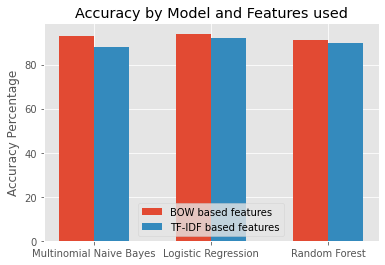

In [28]:
N = 3
CV_means = (93,94,91)
TV_means = (88,92,90)

ind = np.arange(N) 
width = .30  
plt.bar(ind, CV_means, width, label='BOW based features')
plt.bar(ind + width, TV_means, width,
    label='TF-IDF based features')

plt.ylabel('Accuracy Percentage')
plt.title('Accuracy by Model and Features used')

plt.xticks(ind + width / 2, ('Multinomial Naive Bayes', 'Logistic Regression', 'Random Forest'))
plt.legend(loc='best')
plt.show()

Accuracy Evaluation: As seen in the bar chart above, the Bag of Word based features utilizing CountVectorizer were more accurate in predicting the recommendation of a product than the TD-IDF based features.  When used in combination with the Multinomial Naive Bayes, Logistic Regression, and Random Forest models, the combination of BOW features with a Logistic Regression model had the best accuracy.

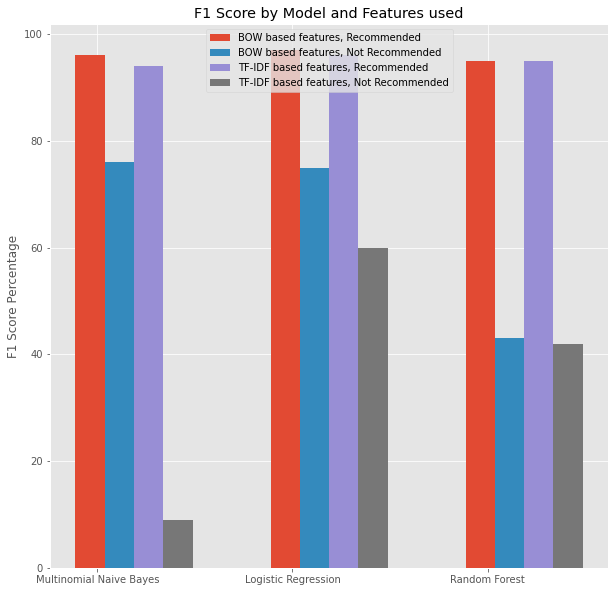

In [38]:
from matplotlib.pyplot import figure
figure(figsize=(10,10))

N = 3
CV_means_rec = (96,97,95)
CV_means_no = (76,75,43)
TV_means_rec = (94,96,95)
TV_means_no = (9,60,42)

ind = np.arange(N) 
width = .15
plt.bar(ind, CV_means_rec, width, label='BOW based features, Recommended')
plt.bar(ind + width, CV_means_no, width, label='BOW based features, Not Recommended')
plt.bar(ind + width + width, TV_means_rec, width,
    label='TF-IDF based features, Recommended')
plt.bar(ind + width + width + width, TV_means_no, width,
    label='TF-IDF based features, Not Recommended')

plt.ylabel('F1 Score Percentage')
plt.title('F1 Score by Model and Features used')

plt.xticks(ind + width / 4, ('Multinomial Naive Bayes', 'Logistic Regression', 'Random Forest'))
plt.legend(loc='best')
plt.show()

F1 score Evaluation: As the F1 score encompasses precision and recall, it can sometimes be a more effective evaluation of a model's performance.  Because the training and testing data contained an overwhelming percentage of recommended products to the percentage of those not recommended, a rate of almost 5 to 1 (see Visualization section).  The best performing models (by F1 score) is Logistic Regression utilizing Bag of Words features and Multinomial Naive Bayes utilizing Bag of Words features.

##Conclusion: 
The results are somewhat skewed toward recommended products as there are significantly more of those recommended in the data.  In the future, pairing down training and test data to even the recommended/not recommended data would help improve F1 score.

Overall, considering both Accuracy and F1 score, the best performing model and most useful to employ moving forward is Logistic Regression utilizing Bag of Words features (Count Vectorizer).  
